In [ ]:
!pip install torch torchvision
!pip install segmentation-models-pytorch
!pip install albumentations
!pip install opencv-python
!pip install kaggle
!pip install pytorch_lightning

from google.colab import files
files.upload()  # Upload kaggle.json here

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d balraj98/massachusetts-buildings-dataset

# Unzip dataset
!unzip massachusetts-buildings-dataset.zip -d dataset


In [ ]:
import os
import torch
import pytorch_lightning as pl
import numpy as np
import albumentations as A
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Data preparation

In [ ]:
BATCH_SIZE = 8
SHUFFLE = False

class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.images = sorted(os.listdir(images_dir))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.images[idx])  # masks have same filenames
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))
        mask = (mask > 128).astype(np.float32)  # Binarize mask

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.unsqueeze(0)  # Add channel dim for mask

train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

train_dataset = SegmentationDataset("dataset/png/train", "dataset/png/train_labels", transform=train_transform)
val_dataset = SegmentationDataset("dataset/png/val", "dataset/png/val_labels", transform=val_transform)
test_dataset = SegmentationDataset("dataset/png/test", "dataset/png/test_labels", transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

# Model

In [ ]:
class BuildingSegModel():
    def __init__(
            self,
            arch, # e.g., "UNET", "FPN", ...
            encoder_name, # e.g., "resnet58", ...
            encoder_weights, # e.g., "imagenet", ...
            in_channels = 3, # our images have RGB channels so default value = 3
            out_classes = 1, # binary classfication task, so default value =1
            loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True), # loss function, default: dice loss, may use other
            **kwargs):
        self.model = smp.create_model(
            arch = arch,
            encoder_name = encoder_name,
            encoder_weights = encoder_weights,
            in_channels = in_channels,
            classes = out_classes,
            **kwargs,
        )
        self.arch = arch
        self.encoder_name = encoder_name
        self.encoder_weights = encoder_weights
        self.loss_fn = loss_fn
        self.train_loss_records = []

    def train_loop(self, train_loader):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.model.train()
        for epoch in tqdm(range(NUM_EPOCHS)):
            train_loss = 0
            for images, masks in train_loader:
                images = images.to(DEVICE)
                masks = masks.to(DEVICE)

                optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.loss_fn(outputs, masks)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            self.train_loss_records.append(train_loss/len(train_loader))
            print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss/len(train_loader):.4f}")

    def evaluate_loss(self,
                      loader): # evaluate the model by the loss function (default dice loss)
        self.model.eval()
        sum_loss = 0
        with torch.no_grad():
            for images, masks in loader:
                images = images.to(DEVICE)
                masks = masks.to(DEVICE)
                outputs = self.model(images)
                loss = self.loss_fn(outputs, masks)
                sum_loss += loss.item()

        print(f"Validation Loss: {sum_loss/len(loader):.4f}")

    def evaluate_all(self,
                     loader):
        """
        evaluate the model using dice loss, iou_score, f1_score, f2_score, accuracy, recall
        """
        self.model.eval()

        dice_loss = 0
        mean_IOU = 0
        mean_f1 = 0
        mean_f2 = 0
        mean_accuracy = 0
        mean_recall = 0

        total_images = len(loader.dataset)  # Total number of images in the dataset

        with torch.no_grad():
            for images, masks in loader:
                images = images.to(DEVICE)
                masks = masks.to(DEVICE)
                logits = self.model(images)
                pred_masks = (logits.sigmoid() > 0.5).float()

                for pred_mask, mask in zip(pred_masks, masks):
                    tp, fp, fn, tn = smp.metrics.get_stats(
                        pred_mask.long(), mask.long(), mode="binary"
                    )

                    per_image_iou = smp.metrics.iou_score(
                        tp, fp, fn, tn, reduction="micro-imagewise"
                    )

                    per_image_f1 = smp.metrics.f1_score(
                        tp, fp, fn, tn, reduction="micro"
                    )

                    per_image_f2 = smp.metrics.fbeta_score(
                        tp, fp, fn, tn, beta = 2, reduction="micro"
                    )

                    per_image_accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")

                    per_image_recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")

                    mean_IOU += per_image_iou
                    mean_f1 += per_image_f1
                    mean_f2 += per_image_f2
                    mean_accuracy += per_image_accuracy
                    mean_recall += per_image_recall

                loss = self.loss_fn(logits, masks)
                dice_loss += loss.item()

        # Calculate means
        mean_IOU /= total_images
        mean_f1 /= total_images
        mean_f2 /= total_images
        mean_accuracy /= total_images
        mean_recall /= total_images
        dice_loss /= len(loader)

        return {
            "dice loss": dice_loss,
            "meanIOU": float(mean_IOU.cpu().numpy()),
            "meanF1" : float(mean_f1.cpu().numpy()),
            "meanF2" : float(mean_f2.cpu().numpy()),
            "meanACCURACY" : float(mean_accuracy.cpu().numpy()),
            "meanRECALL" : float(mean_recall.cpu().numpy())
        }

def save_evaluation(model, loader, save_dir):
    arch = model.arch
    encoder_name = model.encoder_name
    encoder_weight = model.encoder_weights
    metrics = model.evaluate_all(loader)

    os.makedirs("./eval", exist_ok=True)

    df = pd.DataFrame([metrics])

    # Add a new column for the model name
    model_name = f"{arch}_{encoder_name}_{encoder_weight}"
    df['Model'] = model_name

    # Rearrange columns to place "Model" first
    df = df[['Model'] + [col for col in df.columns if col != 'Model']]

    if os.path.exists(save_dir):
        df.to_csv(save_dir, mode="a", header=False, index=False)
    else:
        df.to_csv(save_dir, index=False)

def plot_loss_curve(model):
    arch = model.arch
    encoder_name = model.encoder_name
    encoder_weight = model.encoder_weights
    training_loss = model.train_loss_records

    save_dir = f"./figure/{arch}/loss_curves"
    os.makedirs(save_dir, exist_ok=True)

    # Create a figure
    plt.figure(figsize=(10, 5))

    # Plot the training loss
    plt.plot(training_loss, marker='o', linestyle='-', color='b')

    # Add labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss (Dice Loss)')
    plt.title('Training Loss Over Epochs')
    plt.xticks(range(len(training_loss)))  # Set x-ticks to match epochs

    # Save the figure
    plt.tight_layout()
    plt.savefig('training_loss.png')

    plt.savefig(os.path.join(save_dir, f"{encoder_name}_{encoder_weight}_loss.png")) # save
    plt.show()  # Show the plot

def visualize(model, loader, num =10):
    """
    visualize the ground truth and predicted mask on the dataset in the loader, where num = number of figure to display in the notebook
    """
    if num > len(loader.dataset):
        print(f"The loader only has {len(loader.dataset)} images!")
        return

    arch = model.arch
    encoder_name = model.encoder_name
    encoder_weight = model.encoder_weights
    model = model.model
    model.eval()

    save_dir = f"./figure/{arch}/"
    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        count = 0
        for images, masks in loader:
            images = images.to(DEVICE)
            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu().numpy() > 0.5
            images = images.cpu().numpy()
            masks = masks.cpu().numpy()

            # Visualize each image in the current batch
            for i in range(images.shape[0]):
                plt.figure(figsize=(12, 4))

                # Add a big title
                plt.suptitle(f"Model: {arch}; {encoder_name}; {encoder_weight}", fontsize=16)

                # Undo normalization for visualization
                img = images[i].transpose(1, 2, 0) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                plt.subplot(1, 3, 1)
                plt.imshow(np.clip(img, 0, 1))
                plt.title("Image")

                plt.subplot(1, 3, 2)
                plt.imshow(masks[i][0], cmap='gray')
                plt.title("Ground Truth")

                plt.subplot(1, 3, 3)
                plt.imshow(preds[i][0], cmap='gray')
                plt.title("Prediction")

                plt.savefig(os.path.join(save_dir, f"{encoder_name}_{encoder_weight}_{count}.png"))

                count += 1
                if count < num:
                    plt.show()


## Train

In [ ]:
NUM_EPOCHS = 80
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BuildingSegModel(
    arch= "UNET", # change the model arch here
    encoder_name= "resnet34", # change the encoder here
    encoder_weights= "imagenet"
)

# Move the model to the device
model.model.to(DEVICE)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
model.train_loop(train_loader)

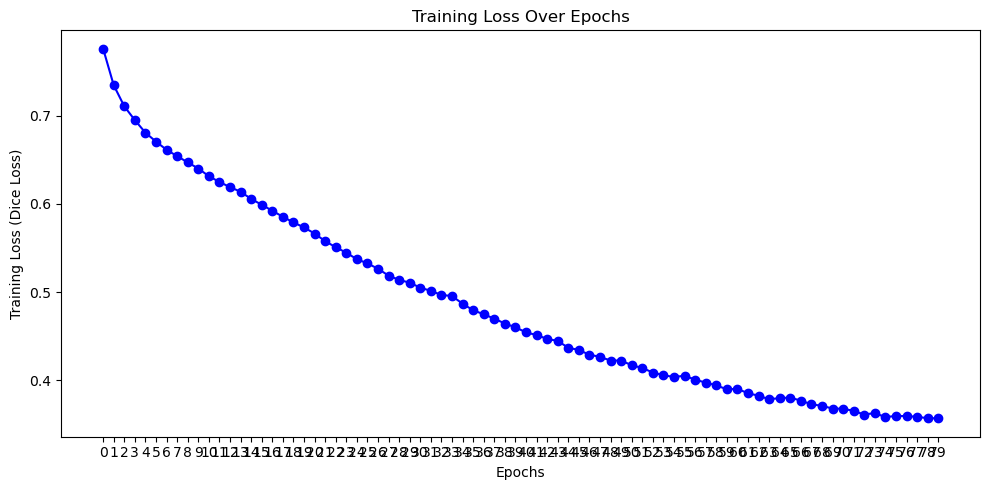

In [ ]:
plot_loss_curve(model) # get the loss curve

In [ ]:
## Save the model
# Define the filename for saving the model
arch = model.arch
encoder_name = model.encoder_name
encoder_weight = model.encoder_weights
save_dir = f"./saved_models"
model_filename = save_dir + f"/{arch}_{encoder_name}_{encoder_weight}_{NUM_EPOCHS}.pkl"

os.makedirs(save_dir, exist_ok=True)
# Save the model using pickle
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

print(f"Model saved to {model_filename}")

## Code for loading the model ##
# filename = ...
# with open(model_filename, 'rb') as file:
#     loaded_model = pickle.load(file)

# print("Model loaded successfully.")

Model saved to ./saved_models/UNET_resnet34_imagenet_80.pkl


## Evaluation

In [ ]:
save_evaluation(model, train_loader, "eval/eval_train.csv")
save_evaluation(model, val_loader, "eval/eval_val.csv")
save_evaluation(model, test_loader, "eval/eval_test.csv")

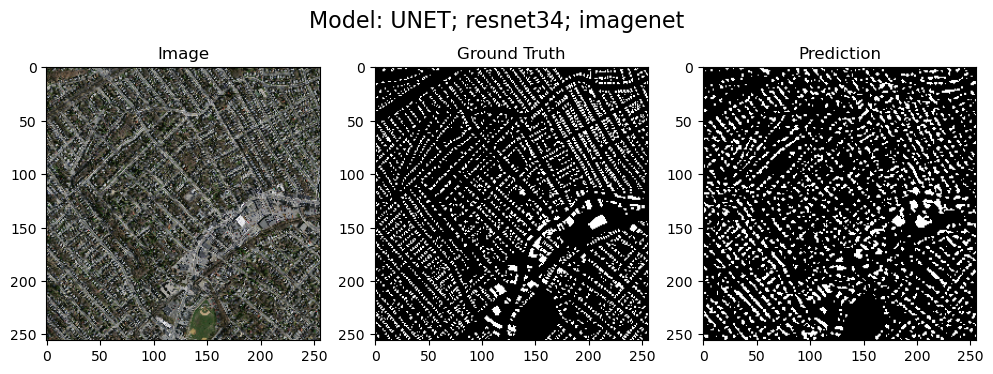

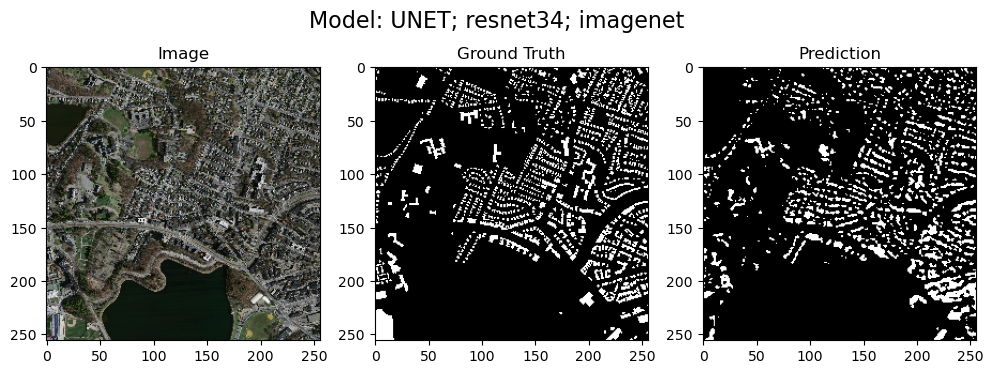

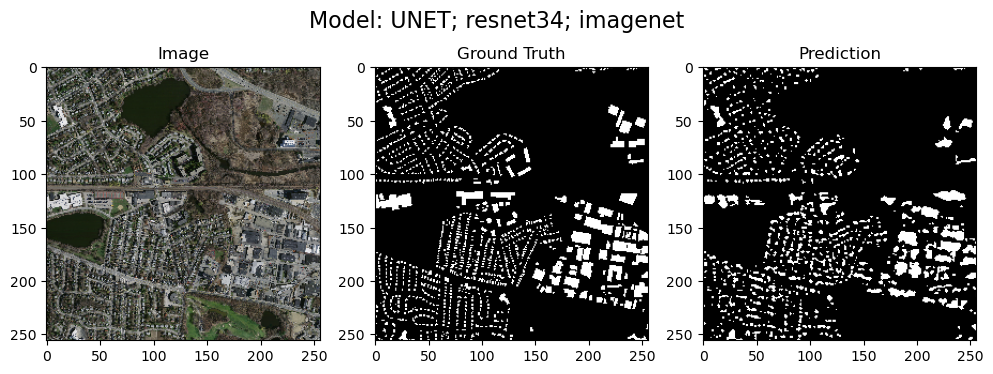

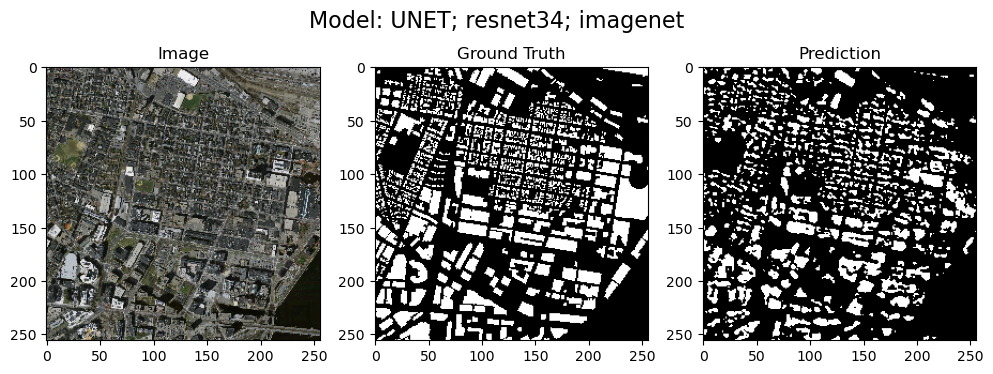

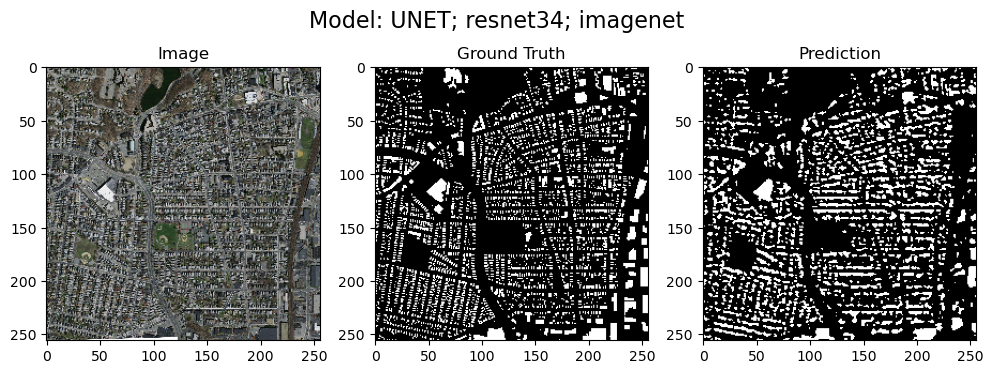

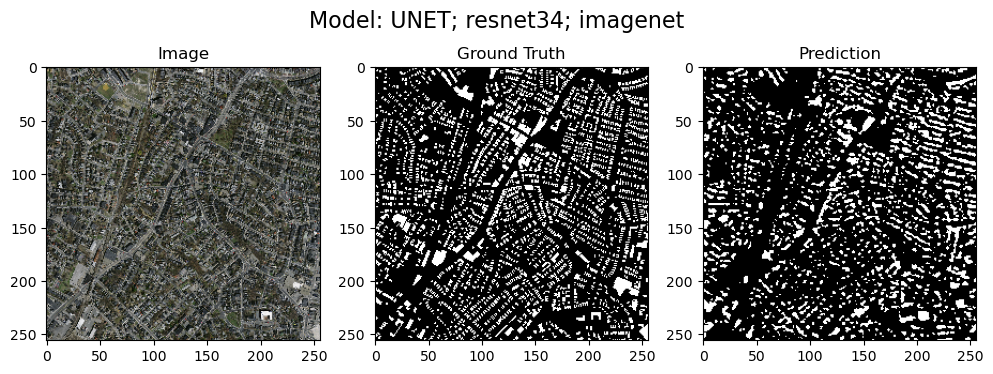

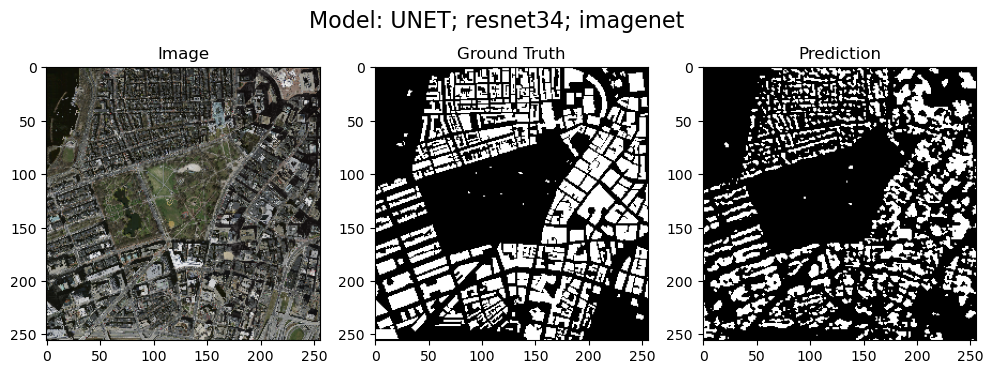

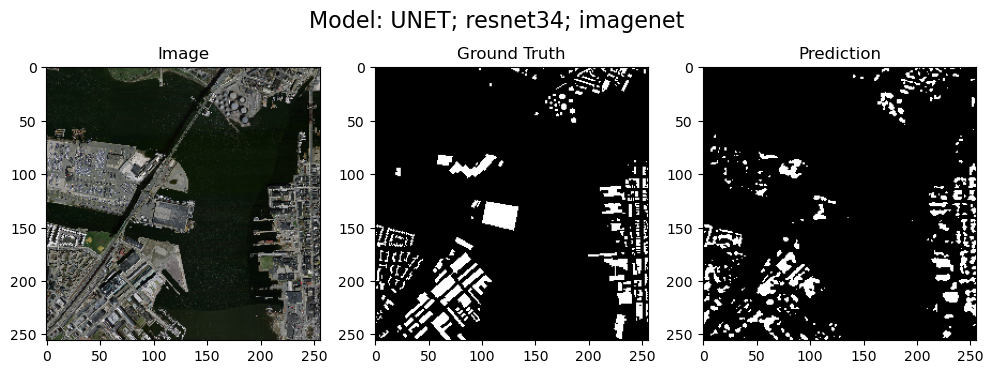

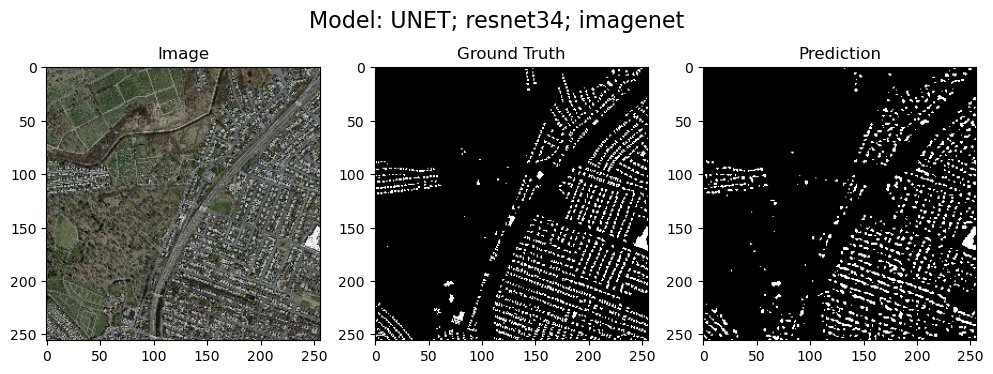

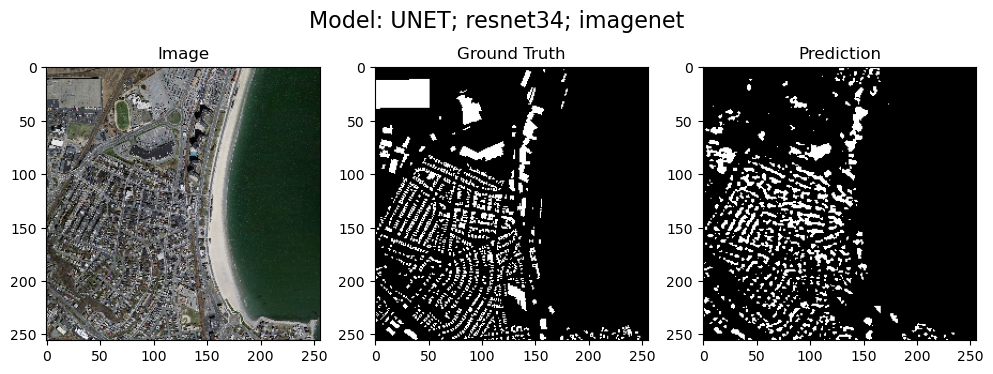

In [ ]:
visualize(model, test_loader)